Packages importation

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from nba_api.stats.endpoints import playercareerstats, playergamelog, leaguegamefinder, playbyplayv2
from nba_api.stats.static import teams, players
from nba_api.stats.library.parameters import SeasonAll
from nba_common_library.lib_string import *
from nba_common_library.utils import *

Setting root dir

In [2]:
cwd_path = os.getcwd()
root_dir = os.path.split(cwd_path)[0]

Grab top 20 players data

In [7]:
target_id_top20 = {players.find_players_by_full_name(name)[0]['id'] : name for name in target_players}

data_top_20 = {id: playergamelog.PlayerGameLog(player_id = id, season = SeasonAll.all).get_data_frames()[0] for id in target_id_top20.keys()}

data_top_20[list(data_top_20.keys())[0]].T

,0,1,2,3,4,5,6,7,8,9,...,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408
SEASON_ID,22022,22022,22022,22022,22022,22022,22022,22022,22022,22022,...,22003,22003,22003,22003,22003,22003,22003,22003,22003,22003
Player_ID,2544,2544,2544,2544,2544,2544,2544,2544,2544,2544,...,2544,2544,2544,2544,2544,2544,2544,2544,2544,2544
Game_ID,0022200798,0022200778,0022200765,0022200749,0022200729,0022200719,0022200705,0022200690,0022200677,0022200664,...,0020300130,0020300115,0020300106,0020300090,0020300078,0020300068,0020300057,0020300038,0020300018,0020300014
GAME_DATE,"FEB 04, 2023","FEB 02, 2023","JAN 31, 2023","JAN 28, 2023","JAN 25, 2023","JAN 24, 2023","JAN 22, 2023","JAN 20, 2023","JAN 18, 2023","JAN 16, 2023",...,"NOV 15, 2003","NOV 14, 2003","NOV 12, 2003","NOV 10, 2003","NOV 08, 2003","NOV 07, 2003","NOV 05, 2003","NOV 01, 2003","OCT 30, 2003","OCT 29, 2003"
MATCHUP,LAL @ NOP,LAL @ IND,LAL @ NYK,LAL @ BOS,LAL vs. SAS,LAL vs. LAC,LAL @ POR,LAL vs. MEM,LAL vs. SAC,LAL vs. HOU,...,CLE vs. PHI,CLE @ BOS,CLE @ MIA,CLE vs. NYK,CLE vs. WAS,CLE @ IND,CLE vs. DEN,CLE @ POR,CLE @ PHX,CLE @ SAC
WL,L,W,W,L,W,L,W,W,L,W,...,W,L,L,W,W,L,L,L,L,L
MIN,40,33,43,44,35,33,36,37,37,36,...,47,35,42,34,45,44,41,39,41,42
FGM,10,11,11,15,8,16,14,8,11,16,...,10,3,6,7,8,8,3,3,8,12
FGA,22,19,25,30,20,29,24,21,25,26,...,19,12,15,12,19,18,11,12,17,20
FG_PCT,0.455,0.579,0.44,0.5,0.4,0.552,0.583,0.381,0.44,0.615,...,0.526,0.25,0.4,0.583,0.421,0.444,0.273,0.25,0.471,0.6


Import files

In [8]:
locations = pd.read_csv(os.path.join(root_dir, data, 'NBA Shot Locations 1997 - 2020.csv'))
teams = pd.DataFrame(teams.get_teams())

In [14]:
def merge_dicts(*dict_args):
    """
    Fusionne plusieurs dictionnaires en un seul en supprimant les clés doublons.
    En cas de conflit, la paire clé-valeur la plus récente est prioritaire.

    Arguments :
    dict_args (tuple) : les dictionnaires à fusionner.

    Returns :
    dict : un nouveau dictionnaire qui est la fusion des dictionnaires fournis en entrée.

    Example :
    >>> d1 = {'a': 1, 'b': 2}
    >>> d2 = {'b': 3, 'c': 4}
    >>> merge_dicts(d1, d2)

    {'a': 1, 'b': 3, 'c': 4}
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

def map_position(root:str):
    """
    Recupère et stock dans un dictionnaire le poste de chaque joueur présent
    dans au moins un deux fichiers CSV référencant les attributs des joueurs.

    Arguments :
    root (str, optional) : Le chemin d'accès du projet.

    Returns :
    dict : Un dictionnaire associant le nom d'un joueur à sa position.

    Example :
    >>> map_position(root_path)
    {'Hakeem Olajuwon': 'C', 'Kareem Abdul-Jabbar': 'C', ...}
    """
    file_path_1 = os.path.join(root_dir, data, 'player_data.csv')
    file_path_2 = os.path.join(root_dir, data, 'Seasons_Stats.csv')

    temp_dict = {}
    for file in [file_path_1, file_path_2]:
        if os.path.exists(file):
            temp_dict[file] = pd.read_csv(file, low_memory=False)
        else:
            raise FileNotFoundError
    # A optimiser la sortie
    return merge_dicts({player: position for player, position in zip(temp_dict[file_path_1].name, temp_dict[file_path_1].position)},
                       {player : position for player, position in zip(temp_dict[file_path_2].Player, temp_dict[file_path_2].Pos)})

map_position_assign = map_position(root = root_dir)
locations['Position'] = locations['Player Name'].map(map_position_assign)
locations.Position.value_counts()

SF     1040538
PG      922291
PF      829571
SG      816936
C       792430
G        70463
F        56690
G-F      21157
F-G       8414
C-F       2796
F-C       2362
Name: Position, dtype: int64

Catégoriser les distance par tranche de 5ft

In [16]:
locations['shot_distance_range'] = locations['Shot Distance'].apply(lambda x: (x // 5) * 5)

Conversion noms vers id

In [18]:
dict_id_team = {team_abb: team_id for team_abb, team_id in zip(teams['abbreviation'], teams['id'])}
locations['Home Team'] = locations['Home Team'].map(dict_id_team)
locations['Away Team'] = locations['Away Team'].map(dict_id_team)
locations.head().T

,0,1,2,3,4
Game ID,29700427,29700427,29700427,29700427,29700427
Game Event ID,389,406,475,487,497
Player ID,100,100,100,100,100
Player Name,Tim Legler,Tim Legler,Tim Legler,Tim Legler,Tim Legler
Team ID,1610612764,1610612764,1610612764,1610612764,1610612764
Team Name,Washington Wizards,Washington Wizards,Washington Wizards,Washington Wizards,Washington Wizards
Period,4,4,4,4,4
Minutes Remaining,11,9,3,1,0
Seconds Remaining,22,36,7,45,45
Action Type,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot


In [21]:
def normalized_counter(data_frame:pd.DataFrame):
    """Fonction non généralisée qui permet de normaliser par rapport aux postes"""
    return(data_frame / locations.Position.value_counts()[data_frame.columns].values * max(locations.Position.value_counts()[data_frame.columns].values)).round(0).astype(int)

Hypothèse 1 :
- Il existe une relation entre le poste du joueur la distance de tir et le taux de conversion

In [ ]:
locations_5st_40ft = locations[(locations['Position'].isin(starter_position)) & locations['shot_distance_range'].isin(np.arange(0, 41, 5))]
table_attempted = normalized_counter(locations_5st_40ft.groupby(['shot_distance_range', 'Position']).count()['Game ID'].unstack(-1))
table_made = normalized_counter(locations_5st_40ft[locations_5st_40ft['Shot Made Flag'] == 1].groupby(['shot_distance_range', 'Position']).count()['Game ID'].unstack(-1))

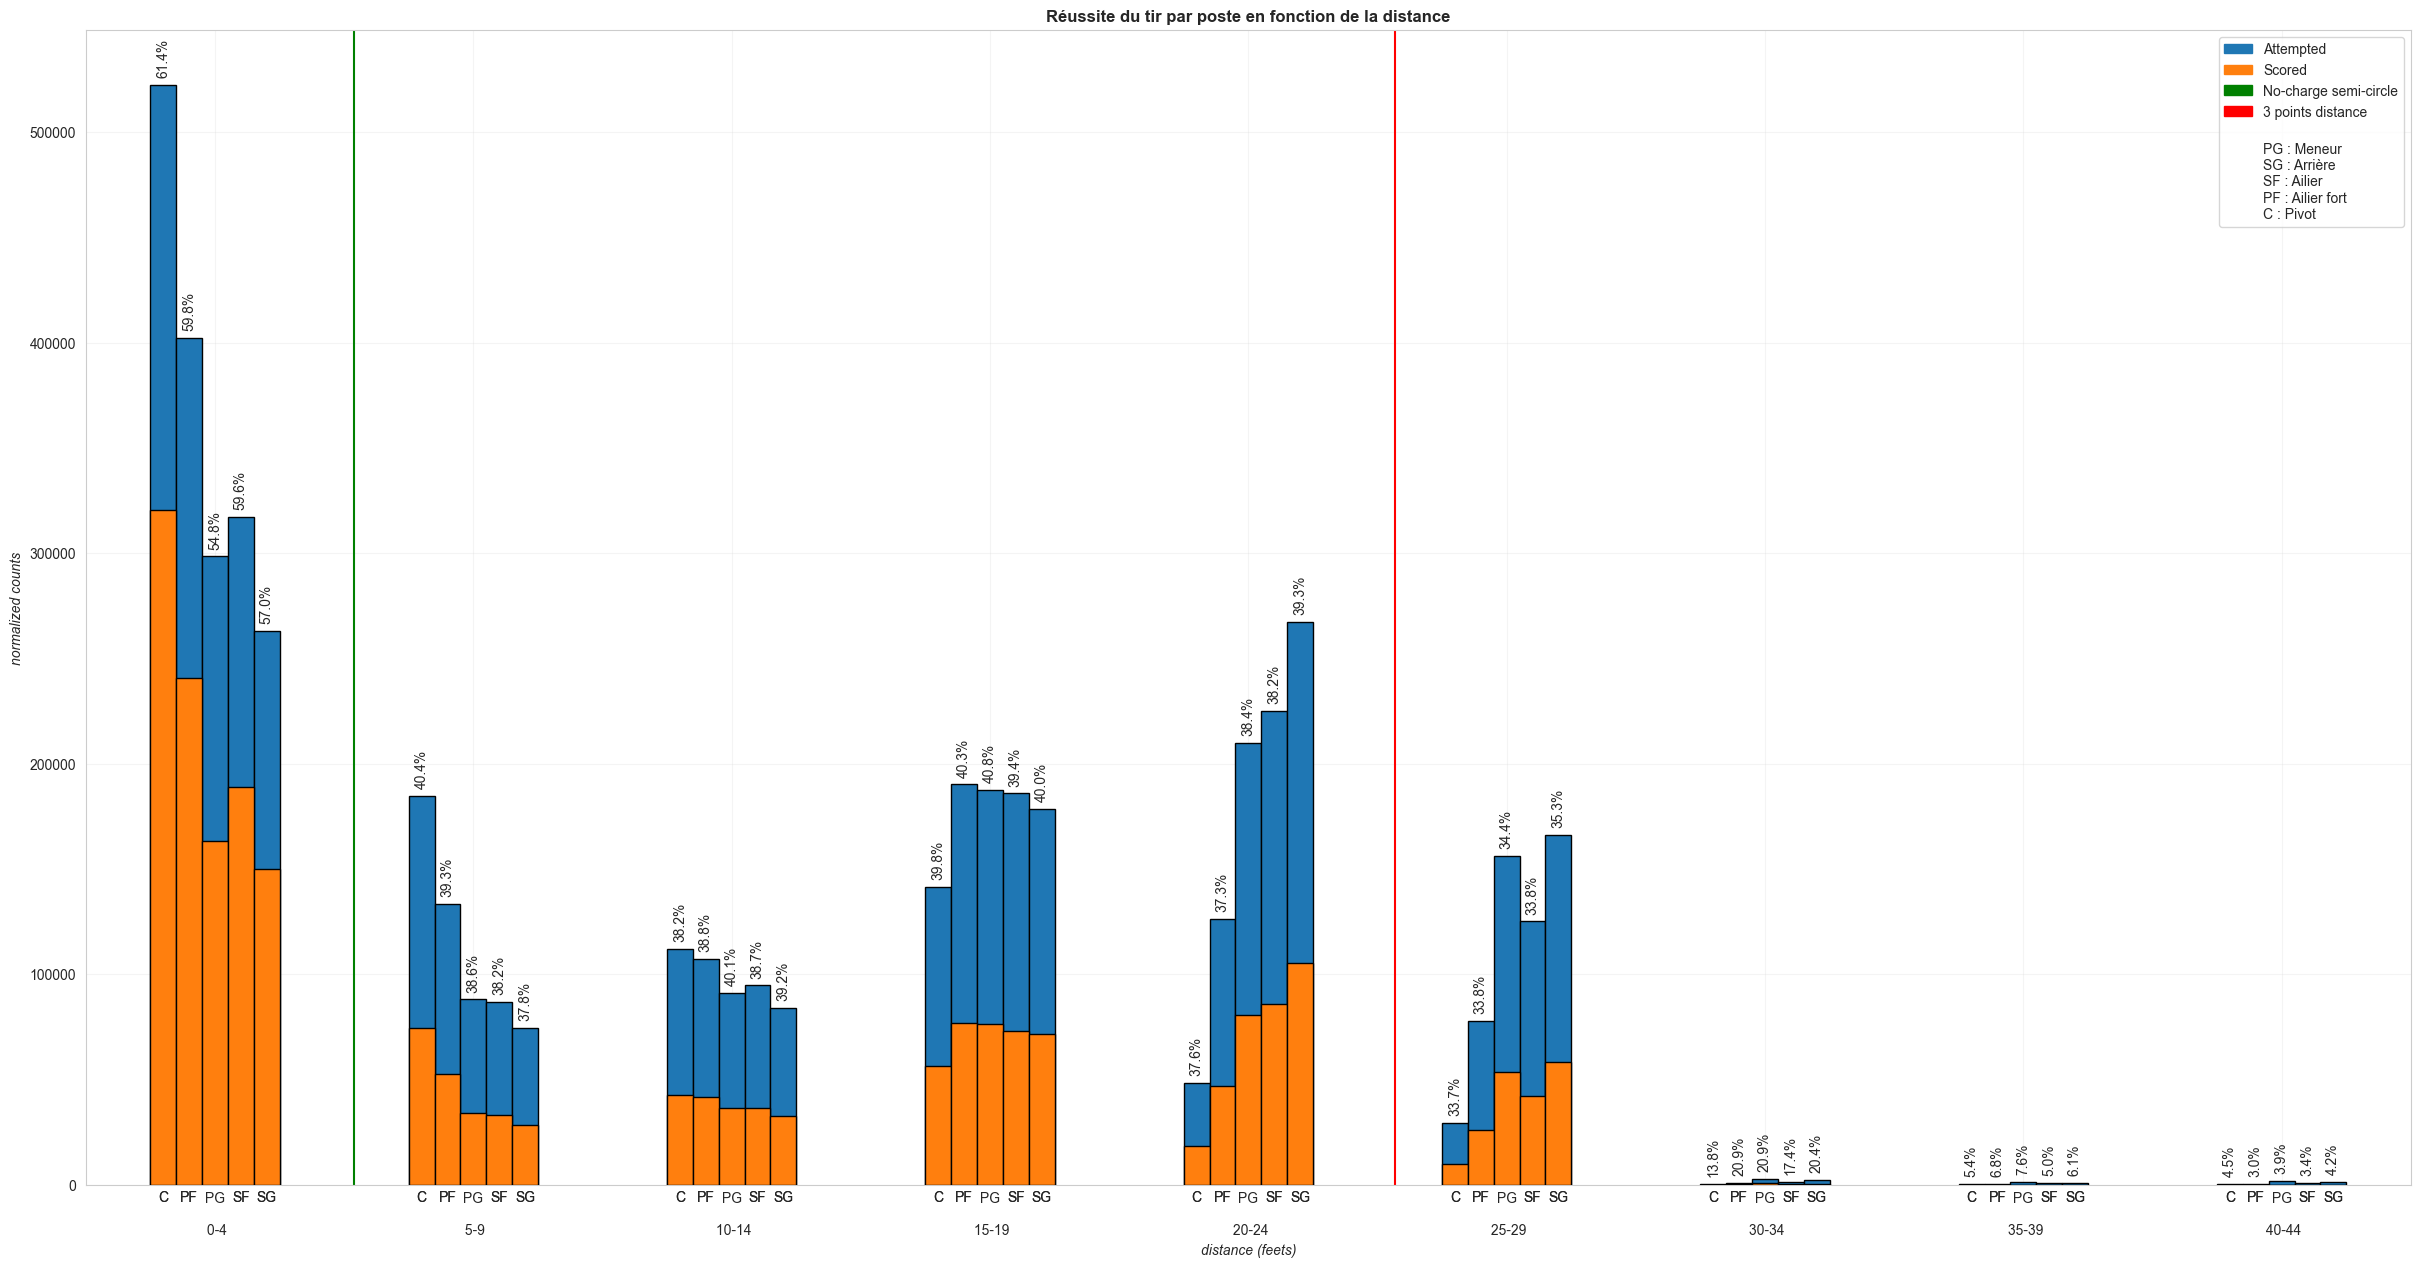

In [237]:
def h1_figure(attempted_:pd.DataFrame, scored_=pd.DataFrame):
    """Fonction non generalisée qui affiche la figure répondant a l'hypothèse 1"""
    fig, ax = plt.subplots(1)
    plt.style.use({'figure.facecolor': 'white'})
    attempted_.plot(kind='bar', figsize=(30,15), color = 'tab:blue', edgecolor='black', ax=ax, label=None, zorder=10)
    scored_.plot(kind='bar', figsize=(30,15), color = 'tab:orange', edgecolor='black', ax=ax, label=None, zorder=10)

    gca = plt.gca()
    positions = [bar.get_x()+bar.get_width()/2. for bar in gca.patches]
    ax.set_xticks(positions, minor=True)
    ax.grid(True, alpha=0.2, zorder=-1)

    lab = list(attempted_.columns)
    labels = sorted(lab * (len(attempted_.index)))*2


    ax.tick_params(axis='x', which='minor', pad=2)
    ax.set_xticklabels([' PG \n\n {}-{}'.format(i, i+4) for i in np.arange(0, 41, 5)], minor=False, rotation=0, fontsize=10)
    ax.tick_params(axis='x', which='major', pad=1);
    ax.set_xlabel('distance (feets)', fontdict={"style": "italic"})
    ax.set_ylabel('normalized counts', fontdict={"style": "italic"})

    counter = 0
    for col in range(attempted_.shape[1]):
        for row in range(attempted_.shape[0]):
            ax.text(positions[counter],
                    attempted_.iloc[row, col] + 5000,
                    f'{((scored_.iloc[row, col] / attempted_.iloc[row, col]) *100).round(1)}%',
                    ha="center", fontsize=10, rotation=90)
            counter += 1

    ax.set_xticklabels(labels, minor=True, fontsize=10)
    ax.axvline(x=4.10 / 7.6, color='green')
    ax.axvline(x=23.75 / 5.2, color='red')
    ax.set_title('Réussite du tir par poste en fonction de la distance', fontweight='bold')
    ax.legend().remove()

    attempted = mpatches.Patch(color='tab:blue', label='Attempted')
    scored = mpatches.Patch(color='tab:orange', label='Scored')
    ubzone = mpatches.Patch(color='green', label='No-charge semi-circle')
    three_pts = mpatches.Patch(color='red', label='3 points distance')
    poste_leg = mpatches.Patch(color='white', label='\nPG : Meneur\nSG : Arrière\nSF : Ailier\nPF : Ailier fort\nC : Pivot')
    ax.legend(handles=[attempted, scored, ubzone, three_pts, poste_leg])
    plt.show();
h1_figure(attempted_=table_attempted, scored_=table_made)

Hypotèse 2 :
- Il existe un lien entre l'équipe tireuse et le type de tirs tentés sur la réussite au tir

In [ ]:
dict_abb_team = {team_full_name : team_abb for team_full_name, team_abb in zip(teams['full_name'], teams['abbreviation'])}
locations['Team Name'] = locations['Team Name'].map(dict_abb_team)

In [238]:
table_at = locations.groupby(['Game ID', 'Team Name', 'Shot Type']).count()['Game Event ID'].reset_index()
table_sc = locations[locations['Shot Made Flag'] == 1].groupby(['Game ID', 'Team Name', 'Shot Type']).count()['Game Event ID'].reset_index()

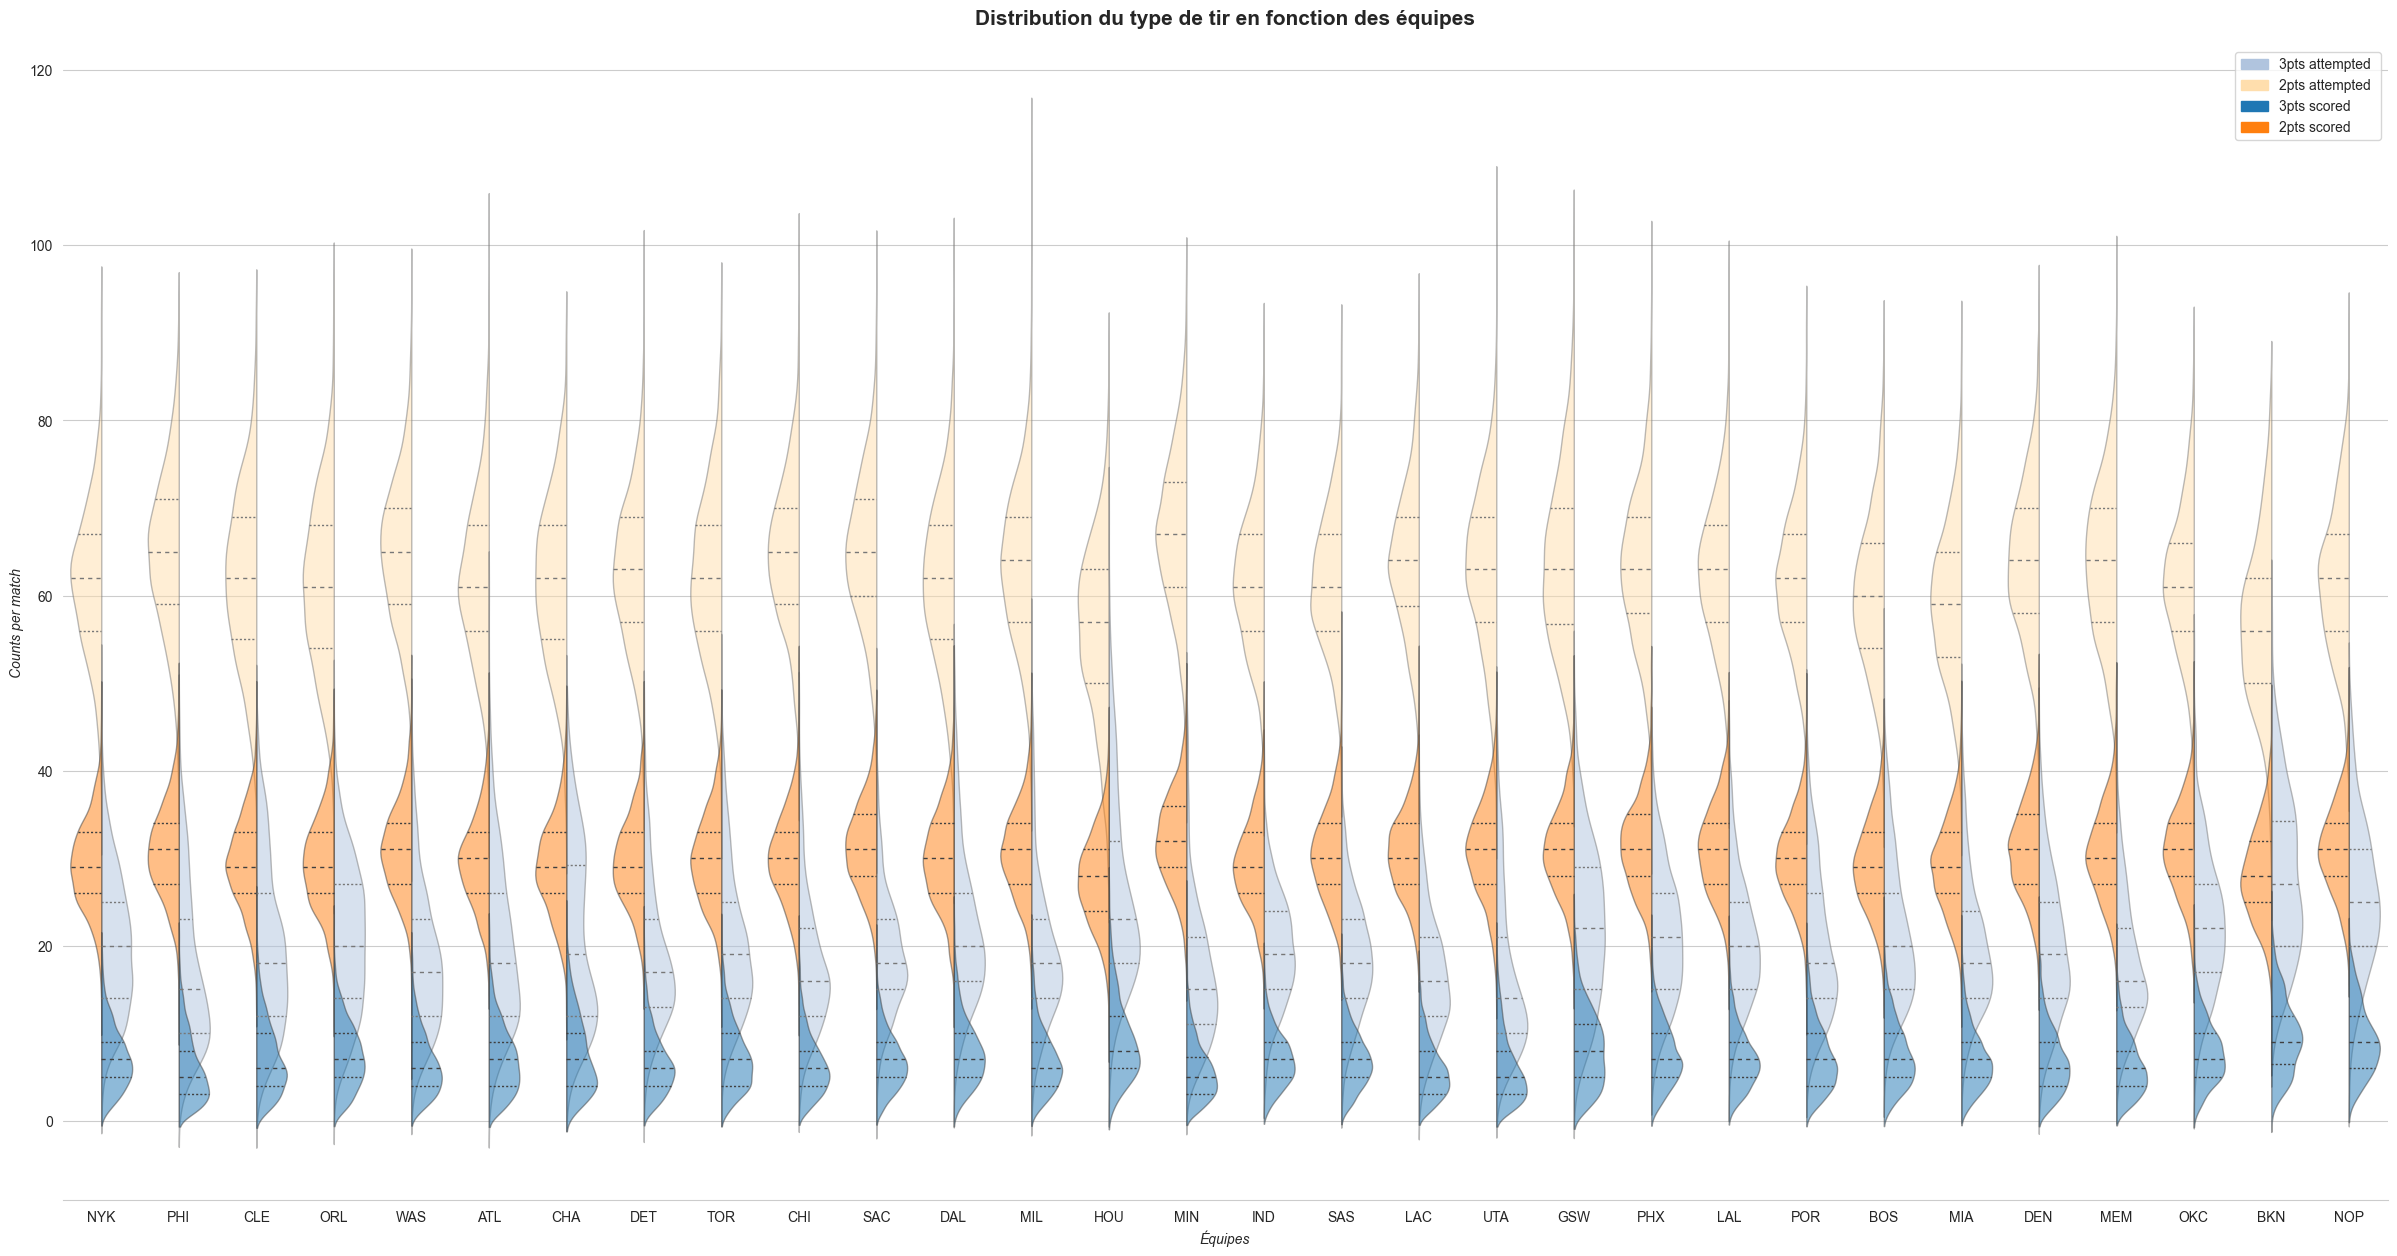

In [239]:
def h2_figure(attempted_:pd.DataFrame, scored_:pd.DataFrame):
    fig, ax = plt.subplots(1, figsize=(30, 15))
    sns.violinplot(data=attempted_, x="Team Name", y="Game Event ID", hue="Shot Type", split=True, inner="quartile", scale='count', palette={"3PT Field Goal": "lightsteelblue", "2PT Field Goal": "navajowhite"},  linewidth=1, saturation=1, ax=ax)
    sns.violinplot(data=scored_, x="Team Name", y="Game Event ID", hue="Shot Type", split=True, inner="quartile", scale='count', palette={"3PT Field Goal": "tab:blue", "2PT Field Goal": "tab:orange"},  linewidth=1, saturation=1, ax=ax)
    sns.despine(left=True)
    ax.legend().remove()

    ax.set_title('Distribution du type de tir en fonction des équipes', fontsize=15, pad=15, fontweight='bold')
    ax.set_xlabel('Équipes', fontdict={"style": "italic"})
    ax.set_ylabel('Tirs par match', fontdict={"style": "italic"})
    attempted_3 = mpatches.Patch(color="lightsteelblue", label='3pts attempted')
    attempted_2 = mpatches.Patch(color="navajowhite", label='2pts attempted ')
    scored_3 = mpatches.Patch(color='tab:blue', label='3pts scored')
    scored_2 = mpatches.Patch(color='tab:orange', label='2pts scored')

    ax.legend(handles=[attempted_3, attempted_2, scored_3, scored_2])
    for violin in ax.collections:
        violin.set_alpha(0.5)

    ax.set_ylabel('Counts per match', fontdict={"style": "italic"})
    plt.show();
h2_figure(attempted_=table_at, scored_=table_sc)

Hypothèse 3 :
- Il existe une relation entre le type de tir effectué le poste et la réussite au tir

In [158]:
locations['shoot_type'] = list(map(lambda x: next((key for key, values in shoot_types.items() if x in values), x), locations['Action Type']))

In [ ]:
df_position = locations[locations['Position'].isin(starter_position)]
df_grouped = df_position.groupby(['shoot_type', 'Position']).count()['Game Event ID'].reset_index()
table_1 = normalized_counter(df_position.groupby(['shoot_type', 'Position']).count()['Game Event ID'].unstack(-1))
table_2 = normalized_counter(df_position[df_position['Shot Made Flag']==1].groupby(['shoot_type', 'Position']).count()['Game Event ID'].unstack(-1))

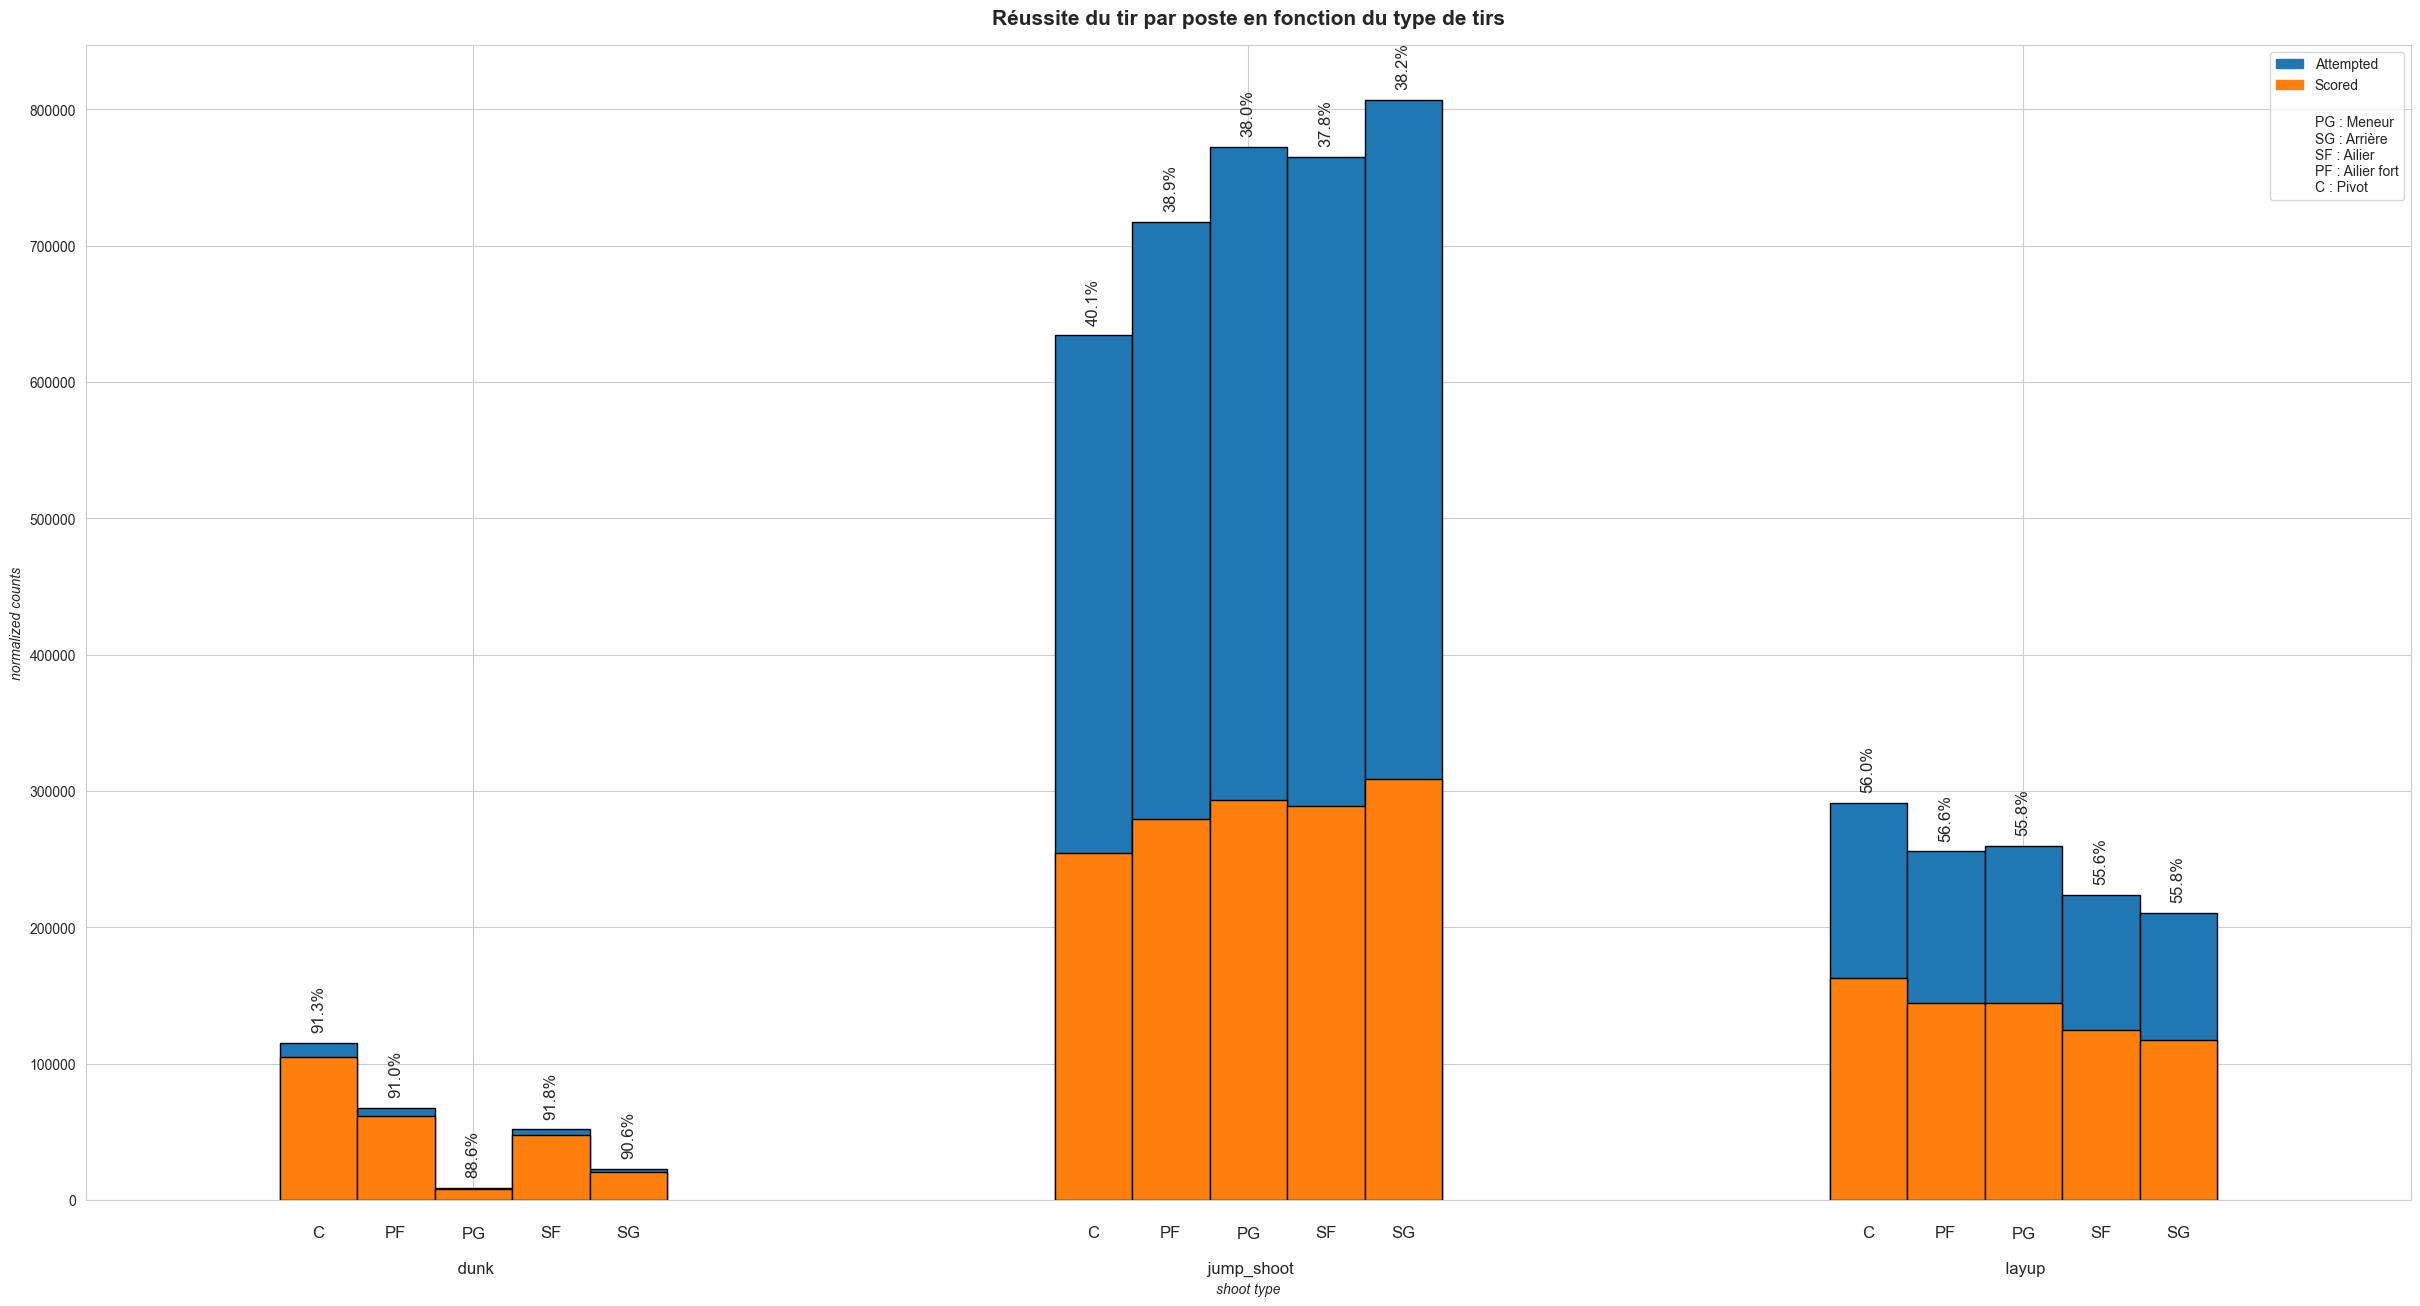

In [232]:
def h3_figure(attempted_:pd.DataFrame, scored_=pd.DataFrame):
    fig, ax = plt.subplots(1)
    plt.style.use({'figure.facecolor': 'white'})
    attempted_.plot(kind='bar', figsize=(30,15), color = 'tab:blue', edgecolor='black', ax=ax, label=None, zorder=10)

    ax = plt.gca()
    pos = []
    for bar in ax.patches:
        pos.append(bar.get_x()+bar.get_width()/2.)

    lab = []
    for i in range(len(pos)):
        l = attempted_.columns.values[i//len(attempted_.index.values)]
        lab.append(f'\n{l}')

    scored_.plot(kind='bar', figsize=(30,15), color = 'tab:orange', edgecolor='black', ax=ax, label=None, zorder=10)

    counter = 0
    for col in range(attempted_.shape[1]):
        for row in range(attempted_.shape[0]):
            ax.text(pos[counter],
                    attempted_.iloc[row, col] + 10000,
                    f'{((scored_.iloc[row, col] / attempted_.iloc[row, col]) *100).round(1)}%',
                    ha="center", fontsize=12, rotation=90)
            counter += 1

    ax.set_xlabel('shoot type', fontdict={"style": "italic"})
    ax.set_ylabel('normalized counts', fontdict={"style": "italic"})
    ax.set_xticks(pos,minor=True)
    ax.set_xticklabels(['PG\n\n {}'.format(i) for i in list(attempted_.index)], minor=False, rotation=0, fontsize=12)
    ax.set_xticklabels(lab,minor=True, fontsize=12)
    ax.tick_params(axis='x', which='major', pad=9, size=10)
    plt.setp(ax.get_xticklabels(), rotation=0)
    ax.set_title('Réussite du tir par poste en fonction du type de tirs', fontsize=15, pad=15, fontweight='bold')
    ax.legend().remove()

    attempted = mpatches.Patch(color='tab:blue', label='Attempted')
    scored = mpatches.Patch(color='tab:orange', label='Scored')
    poste_legend = mpatches.Patch(color='white', label='\nPG : Meneur\nSG : Arrière\nSF : Ailier\nPF : Ailier fort\nC : Pivot')
    ax.legend(handles=[attempted, scored, poste_legend]);

    plt.show()

h3_figure(attempted_=table_1, scored_=table_2)

Hypothèse 4 :
- Il existe une relation entre la taille, le type de tir et la réussite au tir (box plot)

In [ ]:
def normalized_size(data_frame:pd.DataFrame):
    """Fonction non généralisée qui permet de normaliser par rapport aux tailles"""
    return(data_frame / locations.height_grouped.value_counts()[data_frame.columns].values * max(locations.height_grouped.value_counts()[data_frame.columns].values)).round(0).astype(int)

In [267]:
players_ = pd.read_csv(os.path.join(root_dir, data, 'Players.csv'))
players_ = players_[~players_.height.isna()]
height_dict = {player: int(taille) for player, taille in zip(players_.Player, players_.height)}
locations['height'] = locations['Player Name'].map(height_dict)
locations['height_grouped'] = locations.height.apply(lambda x: round(x, -1))

In [273]:
df_position = locations[locations['Position'].isin(starter_position)]
table_1 = normalized_size(df_position.groupby(['shoot_type', 'height_grouped']).count()['Game Event ID'].unstack(-1).fillna(0))
table_2 = normalized_size(df_position[df_position['Shot Made Flag']==1].groupby(['shoot_type', 'height_grouped']).count()['Game Event ID'].unstack(-1).fillna(0))

/var/folders/_z/m9mrvx6j14s1w4n961v7j2800000gn/T/ipykernel_43700/2942248789.py:23: RuntimeWarning: invalid value encountered in scalar divide
  f'{((scored_.iloc[row, col] / attempted_.iloc[row, col]) *100).round(1)}%',


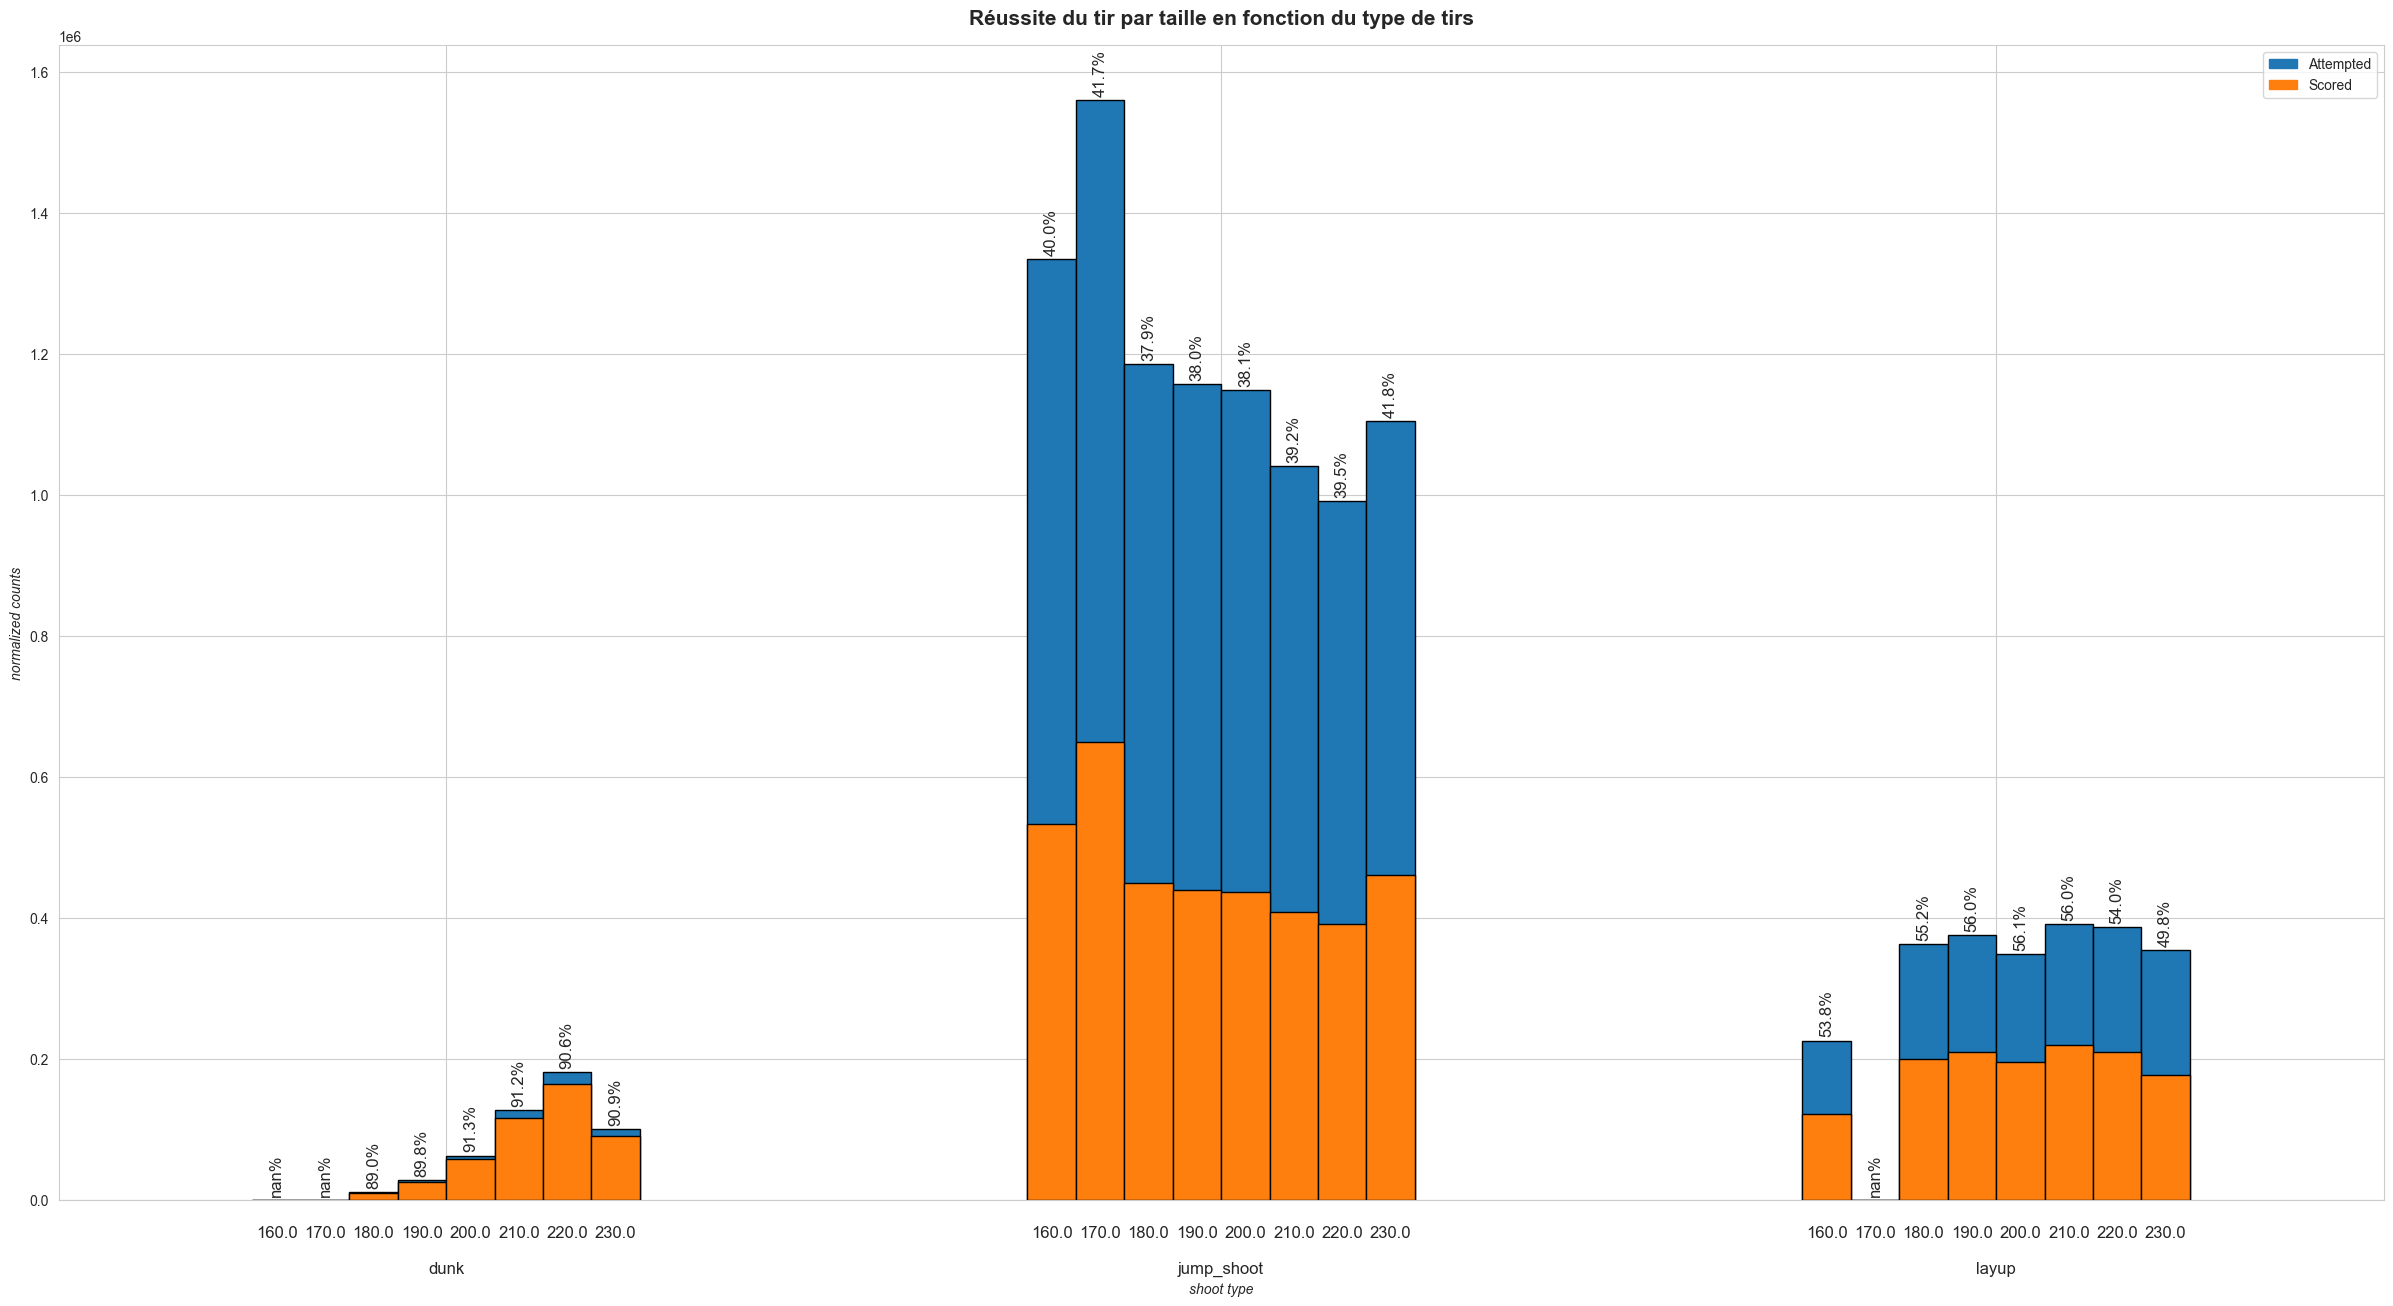

In [290]:
def h4_figure(attempted_:pd.DataFrame, scored_=pd.DataFrame):
    fig, ax = plt.subplots(1)
    plt.style.use({'figure.facecolor': 'white'})
    attempted_.plot(kind='bar', figsize=(30,15), color = 'tab:blue', edgecolor='black', ax=ax, label=None, zorder=10)

    ax = plt.gca()
    pos = []
    for bar in ax.patches:
        pos.append(bar.get_x()+bar.get_width()/2.)

    lab = []
    for i in range(len(pos)):
        l = attempted_.columns.values[i//len(attempted_.index.values)]
        lab.append(f'\n{l}')

    scored_.plot(kind='bar', figsize=(30,15), color = 'tab:orange', edgecolor='black', ax=ax, label=None, zorder=10)

    counter = 0
    for col in range(attempted_.shape[1]):
        for row in range(attempted_.shape[0]):
            ax.text(pos[counter],
                    attempted_.iloc[row, col] + 10000,
                    f'{((scored_.iloc[row, col] / attempted_.iloc[row, col]) *100).round(1)}%',
                    ha="center", fontsize=12, rotation=90)
            counter += 1

    ax.set_xlabel('shoot type', fontdict={"style": "italic"})
    ax.set_ylabel('normalized counts', fontdict={"style": "italic"})
    ax.set_xticks(pos,minor=True)
    ax.set_xticklabels(['\n\n{}'.format(i) for i in list(attempted_.index)], minor=False, rotation=0, fontsize=12)
    ax.set_xticklabels(lab,minor=True, fontsize=12)
    ax.tick_params(axis='x', which='major', pad=9, size=10)
    plt.setp(ax.get_xticklabels(), rotation=0)
    ax.set_title('Réussite du tir par taille en fonction du type de tirs', fontsize=15, pad=15, fontweight='bold')
    ax.legend().remove()

    attempted = mpatches.Patch(color='tab:blue', label='Attempted')
    scored = mpatches.Patch(color='tab:orange', label='Scored')
    ax.legend(handles=[attempted, scored])

    plt.show()

h4_figure(attempted_=table_1, scored_=table_2)

Hypothèse 5 :
- Il existe une relation entre la réussite au tirs et la réception ou non du match (box plot)

In [291]:
locations

,Game ID,Game Event ID,Player ID,Player Name,Team ID,Team Name,Period,Minutes Remaining,Seconds Remaining,Action Type,...,Shot Made Flag,Game Date,Home Team,Away Team,Season Type,Position,shot_distance_range,shoot_type,height,height_grouped
0,29700427,389,100,Tim Legler,1610612764,WAS,4,11,22,Jump Shot,...,1,19980102,1.610613e+09,1.610613e+09,Regular Season,SG,15,jump_shoot,193.0,190.0
1,29700427,406,100,Tim Legler,1610612764,WAS,4,9,36,Jump Shot,...,0,19980102,1.610613e+09,1.610613e+09,Regular Season,SG,10,jump_shoot,193.0,190.0
2,29700427,475,100,Tim Legler,1610612764,WAS,4,3,7,Jump Shot,...,0,19980102,1.610613e+09,1.610613e+09,Regular Season,SG,10,jump_shoot,193.0,190.0
3,29700427,487,100,Tim Legler,1610612764,WAS,4,1,45,Jump Shot,...,0,19980102,1.610613e+09,1.610613e+09,Regular Season,SG,5,jump_shoot,193.0,190.0
4,29700427,497,100,Tim Legler,1610612764,WAS,4,0,45,Jump Shot,...,0,19980102,1.610613e+09,1.610613e+09,Regular Season,SG,10,jump_shoot,193.0,190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4729507,41800406,366,2738,Andre Iguodala,1610612744,GSW,3,7,51,Pullup Jump shot,...,0,20190613,1.610613e+09,1.610613e+09,Playoffs,SF,15,jump_shoot,198.0,200.0
4729508,41800406,392,2738,Andre Iguodala,1610612744,GSW,3,6,8,Jump Shot,...,1,20190613,1.610613e+09,1.610613e+09,Playoffs,SF,20,jump_shoot,198.0,200.0
4729509,41800406,404,2738,Andre Iguodala,1610612744,GSW,3,4,41,Floating Jump shot,...,1,20190613,1.610613e+09,1.610613e+09,Playoffs,SF,0,jump_shoot,198.0,200.0
4729510,41800406,468,2738,Andre Iguodala,1610612744,GSW,3,1,7,Jump Shot,...,1,20190613,1.610613e+09,1.610613e+09,Playoffs,SF,25,jump_shoot,198.0,200.0


In [296]:
leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22022,1612709902,SCW,Santa Cruz Warriors,2022200252,2023-02-09,SCW @ WCB,L,240,112,...,0.700,13,39,52,32,2,6,14,19,-4.0
1,22022,1612709924,ONT,Ontario Clippers,2022200253,2023-02-09,ONT vs. SBL,L,240,117,...,0.833,15,29,44,20,8,1,10,21,-4.4
2,22022,1612709931,MXC,Mexico City Capitanes,2022200251,2023-02-09,MXC @ MHU,L,240,99,...,0.571,10,30,40,21,5,6,15,15,-7.6
3,22022,1612709905,SBL,South Bay Lakers,2022200253,2023-02-09,SBL @ ONT,W,240,122,...,0.882,10,33,43,20,5,8,15,15,6.4
4,22022,1612709926,MHU,Memphis Hustle,2022200251,2023-02-09,MHU vs. MXC,W,240,111,...,0.857,14,33,47,27,8,3,12,10,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,22017,1611661325,IND,Indiana Fever,1021700130,2017-07-28,IND vs. NYL,L,200,84,...,1.000,3,18,21,21,7,6,10,19,-1.0
29996,22017,1611661320,LAS,Los Angeles Sparks,1021700132,2017-07-28,LAS @ SAN,W,200,85,...,0.778,3,26,29,22,7,5,8,14,12.0
29997,22017,1611661329,CHI,Chicago Sky,1021700133,2017-07-28,CHI vs. PHO,L,200,80,...,0.750,9,26,35,20,7,6,13,18,-6.0
29998,22017,1611661319,SAN,San Antonio Stars,1021700132,2017-07-28,SAN vs. LAS,L,200,73,...,0.900,5,25,30,17,4,0,12,12,-12.0


Hypothèse 6 :
- Il existe une relation entre le taux de réussite au tirs des 5 dernier match et la reussite au tir général (box plot groupé)

In [233]:
locations.head().T
#df.boxplot(column=list(df.columns))

,0,1,2,3,4
Game ID,29700427,29700427,29700427,29700427,29700427
Game Event ID,389,406,475,487,497
Player ID,100,100,100,100,100
Player Name,Tim Legler,Tim Legler,Tim Legler,Tim Legler,Tim Legler
Team ID,1610612764,1610612764,1610612764,1610612764,1610612764
Team Name,WAS,WAS,WAS,WAS,WAS
Period,4,4,4,4,4
Minutes Remaining,11,9,3,1,0
Seconds Remaining,22,36,7,45,45
Action Type,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot


Hypothèse 6 :
- Il existe une relation entre la zone du tirs la reussite du tir (heat map ? )

In [235]:
locations['Shot Zone Basic'].unique()

array(['Mid-Range', 'In The Paint (Non-RA)', 'Left Corner 3',
       'Right Corner 3', 'Above the Break 3', 'Restricted Area',
       'Backcourt'], dtype=object)

In [1]:
import os
os.listdir('/Users/giovanni/Courses/GitHub/JAN23_BDS_NBA')

['nba_common_library',
 '.DS_Store',
 'requirements.txt',
 'README.md',
 '.gitignore',
 '.git',
 'streamlit_app',
 'Rapport de projet.docx',
 'data',
 'notebooks']